# import

In [50]:

import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import CCA
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt
import scipy 
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample
from statsmodels.stats.multitest import fdrcorrection
from sklearn.model_selection import KFold


def compute_fold_wise_cross_validation(X_scaled,Y_scaled):
    #PARAMETERS 
    n_components_cca = 4  # your CCA components
    n_splits = 5           # cross-validation folds
    n_shuffles = 200
    seed = 7

    # compute canonical covariance
    def canonical_cov(U, V):
        # Absolute covariance per canonical mode
        return np.array([np.cov(U[:, i], V[:, i], ddof=1)[0,1] for i in range(U.shape[1])])

    # STEP 1: Cross-validated canonical covariances
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    cv_covs = []
    for train_idx, test_idx in kf.split(X_scaled):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        Y_train, Y_test = Y_scaled[train_idx], Y_scaled[test_idx]
        cca = CCA(n_components=n_components_cca)
        cca.fit(X_train, Y_train)
        U_test, V_test = cca.transform(X_test, Y_test)
        # cv_covs.append(canonical_cov(U_test, V_test))
        cv_covs.append(abs(canonical_cov(U_test, V_test))/sum(abs(canonical_cov(U_test, V_test))))
    cv_covs = np.array(cv_covs)

    # STEP 2: Fold-wise null 
    null_covs_all = np.zeros((n_shuffles, n_components_cca))
    for i in range(n_shuffles):
        fold_covs = []
        for train_idx, test_idx in kf.split(X_scaled):
            X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
            Y_train, Y_test = Y_scaled[train_idx], Y_scaled[test_idx]
            # Shuffle only the training Y
            Y_train_shuffled = np.random.permutation(Y_train)
            cca = CCA(n_components=n_components_cca)
            cca.fit(X_train, Y_train_shuffled)
            U_test, V_test = cca.transform(X_test, Y_test)
            fold_covs.append(canonical_cov(U_test, V_test))
        null_covs_all[i] = np.mean(fold_covs, axis=0)

    return cv_covs, null_covs_all



def plot_correlation_permutation(X_scaled,Y_scaled,num_plot):
    if num_plot > 2:
        num_plot = 2
    n_components = num_plot
    pvals = []
    n_perms = 1000
    fig, ax = plt.subplots(1, n_components, figsize=(6, 3))
    for i in range(n_components):

        # True correlation
        X_c, Y_c = cca.fit_transform(X_scaled, Y_scaled)

        perm_r = []
        for _ in range(n_perms):
            Y_perm = np.random.permutation(Y_scaled)
            _, Y_c_perm = cca.fit_transform(X_scaled, Y_perm)
            r_perm, _ = pearsonr(X_c[:, i], Y_c_perm[:, i])
            perm_r.append(r_perm)
        
        r_true, _ = pearsonr(X_c[:, i], Y_c[:, i])

        p_val = np.mean(np.array(perm_r) >= r_true)
        
        pvals += [float(p_val)]

        if num_plot > 1:
            ax[i].hist(perm_r, bins=30, alpha=0.3, label='Permuted', color = 'k')
            ax[i].axvline(r_true, color="gold", linewidth=2, label=f'Observed r = {r_true:.2f}', linestyle=':')
            ax[i].set_xlabel("Canonical correlation")
            ax[i].set_ylabel("Frequency")
            ax[i].legend()
        else:
            ax.hist(perm_r, bins=30, alpha=0.3, label='Permuted', color = 'k')
            ax.axvline(r_true, color="gold", linewidth=2, label=f'Observed r = {r_true:.2f}', linestyle=':')
            ax.set_xlabel("Canonical correlation")
            ax.set_ylabel("Frequency")
            ax.legend()
    


def plot_canonical_variates(X_c, Y_c,num_variates):
    """
    Plots the canonical variates.
    """
    fig, ax = plt.subplots(1, num_variates, figsize=(9, 4))
    for i in range(num_variates):
        # Correlation between canonical variates
        r, _ = pearsonr(X_c[:, i], Y_c[:, i])
        print(f"Canonical correlation (component {i+1}): {r:.3f}")
        # Plot the canonical variates
        if num_variates > 1:
            ax[i].scatter(X_c[:, i], Y_c[:, i], color = 'k', alpha = 0.5)
            ax[i].set_xlabel('Behaviour (Canonical)')
            ax[i].set_ylabel('Replay (Canonical)')
            ax[i].set_title(f'r = {r:.2f} component {i+1}')
            
            # Fit regression model
            model = LinearRegression()
            model.fit(X_c[:, i].reshape(-1, 1), Y_c[:, i].reshape(-1, 1))

            # Predict y values
            y_pred = model.predict(X_c[:, i].reshape(-1, 1))

            ax[i].plot(X_c[:, i], y_pred, color='gold', label="Regression line")
            if i > 0:
                break
        else:
            ax.scatter(X_c[:, i], Y_c[:, i], color = 'k', alpha = 0.5)
            ax.set_xlabel('Behaviour (Canonical)')
            ax.set_ylabel('Replay (Canonical)')
            ax.set_title(f'r = {r:.2f} component {i+1}')
            
            # Fit regression model
            model = LinearRegression()
            model.fit(X_c[:, i].reshape(-1, 1), Y_c[:, i].reshape(-1, 1))

            # Predict y values
            y_pred = model.predict(X_c[:, i].reshape(-1, 1))

            ax.plot(X_c[:, i], y_pred, color='gold', label="Regression line")
            if i > 0:
                break

def plot_weights_delta(X_scaled,Y_scaled,component):
    cca = CCA(n_components=n_components)
    X_c, Y_c = cca.fit_transform(X_scaled, Y_scaled)
    x_weights = cca.x_weights_[:, 0]
    y_weights = cca.y_weights_[:, 0]
    # Bootstrap ---
    n_boots = 1000
    x_weights_all = np.zeros((n_boots, X_scaled.shape[1]))
    y_weights_all = np.zeros((n_boots, Y_scaled.shape[1]))
    for i in range(n_boots):
        idx = np.random.choice(len(X_scaled), size=len(X_scaled), replace=True)
        X_boot = X_scaled[idx]
        Y_boot = Y_scaled[idx]
        cca.fit(X_boot, Y_boot)
        x_weights_all[i] = cca.x_weights_[:, 0]
        y_weights_all[i] = cca.y_weights_[:, 0]

    # Compute confidence intervals ---
    x_mean = x_weights_all.mean(axis=0)
    y_mean = y_weights_all.mean(axis=0)
    y_err = scipy.stats.sem(x_weights_all, axis=0)
    x_err = scipy.stats.sem(y_weights_all, axis=0)
    # Sort by absolute weight magnitude
    sorted_idx_x = np.argsort(x_mean)
    sorted_idx_y = np.argsort(y_mean)
    # Behaviour
    beh_names = ['delta Movement variability','delta Movement speed', 'delta Total expression','delta Proportion linked to reward','delta Error rate']
    beh_vals = y_mean[sorted_idx_y]
    # Replay
    rep_names = ['Event rate', 'Event length','Mean warp', 'forward/reverse proportion','Neuron Awake consistency','Expression difference to expected']
    rep_vals = x_mean[sorted_idx_x]

    # Plot
    fig, axes = plt.subplots(1, 1, figsize=(5, 3))
    axes.barh(rep_names, rep_vals, xerr=y_err, color='#DD6F54', alpha=0.8)
    axes.set_title('Canonical Weights – Replay')
    axes.axvline(0, color='black', linewidth=0.8)
    fig, axes = plt.subplots(1, 1, figsize=(5, 3))
    axes.barh(beh_names, beh_vals, xerr= x_err, color='#1F668C', alpha=0.8)
    axes.set_title('Canonical Weights – Behaviour')
    axes.axvline(0, color='black', linewidth=0.8)
    plt.gca().invert_yaxis()


def stadardise_data(X, Y):
    """
    Standardizes the input data X and Y.
    """
    X_scaled = StandardScaler().fit_transform(X)
    Y_scaled = StandardScaler().fit_transform(Y)
    return X_scaled, Y_scaled

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import CCA

def canonical_covariance_share(X_scaled, Y_scaled, n_components, unit_variance=False):
    """
    Computes canonical covariance (absolute, not normalized) between X and Y.
    Set unit_variance=True to get covariance ≈ correlation.
    """
    k_max = min(X_scaled.shape[1], Y_scaled.shape[1], X_scaled.shape[0]-1)
    k = min(n_components, k_max)

    cca = CCA(n_components=k)
    U, V = cca.fit_transform(X_scaled, Y_scaled)  # (n,k), (n,k)

    # Align signs so correlation >= 0
    r = np.array([np.corrcoef(U[:, i], V[:, i])[0, 1] for i in range(k)])
    for i in range(k):
        if r[i] < 0:
            V[:, i] *= -1
            r[i] = -r[i]

    if unit_variance:
        # Normalize each score to unit variance so cov == corr
        U = (U - U.mean(axis=0)) / U.std(axis=0, ddof=1)
        V = (V - V.mean(axis=0)) / V.std(axis=0, ddof=1)

    covs = np.array([np.cov(U[:, i], V[:, i], ddof=1)[0, 1] for i in range(k)])
    total = covs.sum()
    props = covs / total if total > 0 else np.zeros_like(covs)

    return props, covs, r

def return_correlation_bootstrapped(X_scaled,Y_scaled):

    n_components = 2
    cca = CCA(n_components)

    # fit once on full dataset
    X_c, Y_c = cca.fit_transform(X_scaled, Y_scaled)

    # original correlations
    orig_corrs = [np.corrcoef(X_c[:, k], Y_c[:, k])[0, 1] for k in range(n_components)]

    # bootstrap parameters
    n_boot = 1000
    boot_corrs = np.zeros((n_boot, n_components))

    for i in range(n_boot):
        # resample indices
        X_res, Y_res = resample(X_scaled, Y_scaled, replace=True)
        
        # refit CCA
        X_c_b, Y_c_b = cca.fit_transform(X_res, Y_res)
        
        # store correlations
        for k in range(n_components):
            boot_corrs[i, k] = np.corrcoef(X_c_b[:, k], Y_c_b[:, k])[0, 1]

    # compute bootstrap confidence intervals
    ci_lower = np.percentile(boot_corrs, 2.5, axis=0)
    ci_upper = np.percentile(boot_corrs, 97.5, axis=0)

    # print results
    for k in range(n_components):
        print(f"Component {k+1}: corr={orig_corrs[k]:.3f}, 95% CI=({ci_lower[k]:.3f}, {ci_upper[k]:.3f})")
        

def cca_bootstrap_ci(X_scaled,Y_scaled,component):
    # --- Step 2: Fit CCA on full data ---
    cca = CCA(n_components=n_components)
    X_c, Y_c = cca.fit_transform(X_scaled, Y_scaled)

    x_weights = cca.x_weights_[:, component]
    y_weights = cca.y_weights_[:, component]

    # --- Step 3: Bootstrap ---
    n_boots = 1000
    x_weights_all = np.zeros((n_boots,np.shape(X_scaled)[1]))
    y_weights_all = np.zeros((n_boots,np.shape(Y_scaled)[1]))

    for i in range(n_boots):
        idx = np.random.choice(len(X_scaled), size=len(X_scaled), replace=True)
        X_boot = X_scaled[idx]
        Y_boot = Y_scaled[idx]
        
        cca.fit(X_boot, Y_boot)
        x_weights_all[i] = cca.x_weights_[:, component]
        y_weights_all[i] = cca.y_weights_[:, component]

    # --- Step 4: Compute confidence intervals ---
    x_mean = x_weights_all.mean(axis=0)
    y_mean = y_weights_all.mean(axis=0)
    x_err = scipy.stats.sem(x_weights_all, axis=0)
    y_err = scipy.stats.sem(y_weights_all, axis=0)
    
    return x_mean,y_mean,x_err,y_err


def plot_weights(X_scaled,Y_scaled,component):

    # get bootstrapped confidence intervals + mean weights
    x_mean,y_mean,x_err,y_err = cca_bootstrap_ci(X_scaled,Y_scaled,component)

    # Sort by absolute weight magnitude
    sorted_idx_x = np.argsort(x_mean)
    sorted_idx_y = np.argsort(y_mean)

    # Behaviour
    beh_names= ['Movement variability','Movement speed', 'Total expression','Proportion linked to reward','Error rate']
    beh_vals = x_mean[sorted_idx_x]

    # Replay
    rep_names = ['Event rate', 'Event length','Mean warp', 'forward/reverse proportion','Neuron Awake consistency','Expression difference to expected']
    rep_vals = y_mean[sorted_idx_y]

    # Plot
    fig, axes = plt.subplots(1, 1, figsize=(5, 3))

    axes.barh(beh_names, beh_vals, xerr= x_err, color="#1F668C", alpha=0.8)
    axes.set_title('Canonical Weights – Behaviour')
    axes.axvline(0, color='black', linewidth=0.8)

    fig, axes = plt.subplots(1, 1, figsize=(5, 3))
    axes.barh(rep_names, rep_vals, xerr=y_err, color="#DD6F54", alpha=0.8)
    axes.set_title('Canonical Weights – Replay')
    axes.axvline(0, color='black', linewidth=0.8)

def cca_scree_absolute_with_null(X_scaled, Y_scaled, rand_,n_components=5, n_shuffles=500):
    if rand_ is not None:
        np.random.seed(rand_)

    # Observed data (absolute, not standardized)
    _, obs_covs, _ = canonical_covariance_share(X_scaled, Y_scaled, n_components, unit_variance=False)

    # Null distribution by shuffling Y
    null_covs_all = np.zeros((n_shuffles, len(obs_covs)))
    for i in range(n_shuffles):
        Y_shuffled = np.random.permutation(Y_scaled)
        _, covs_null, _ = canonical_covariance_share(X_scaled, Y_shuffled, n_components, unit_variance=False)
        null_covs_all[i] = covs_null

    # Compute 5th and 95th percentiles
    null_lower = np.percentile(null_covs_all, 5, axis=0)
    null_upper = np.percentile(null_covs_all, 95, axis=0)

    # Plot
    xs = np.arange(1, len(obs_covs)+1)
    plt.figure(figsize=(6,4))
    plt.plot(xs, obs_covs, marker='o', color='blue', label='Observed')
    plt.fill_between(xs, null_lower, null_upper, color='gray', alpha=0.3, label='Null 5-95% CI')
    plt.xticks(xs)
    plt.xlabel('Canonical pair')
    plt.ylabel('Canonical covariance (absolute)')
    plt.title('CCA canonical covariance (absolute) with null')
    plt.legend()
    plt.grid(alpha=0.3)




# figure B

In [2]:
bts_outcome_matrix = pd.read_csv(r"C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\f4\bts_outcome.csv")
bts_predictor_matrix = pd.read_csv(r"C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\f4\bts_predictor.csv")
# scale and standardise the data
X_scaled, Y_scaled = stadardise_data(bts_predictor_matrix,bts_outcome_matrix)

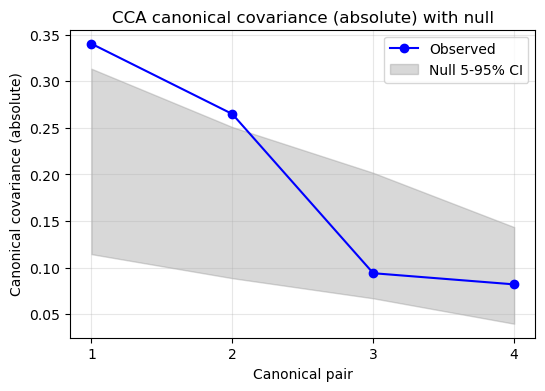

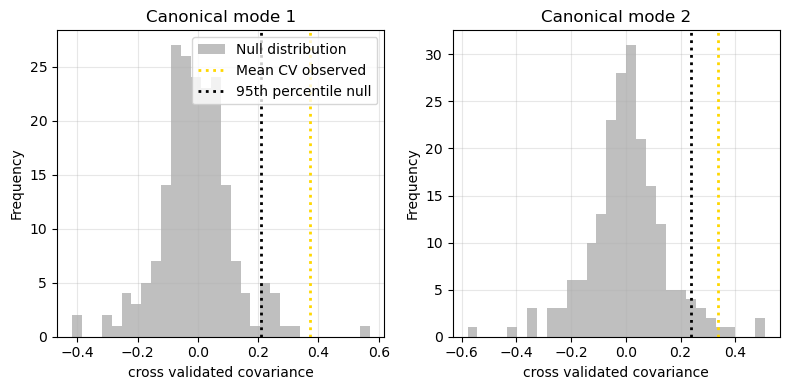

In [3]:
# Usage
cca_scree_absolute_with_null(X_scaled, Y_scaled, 6, n_components=4, n_shuffles=1000)

# cross validation
cv_covs, null_covs_all = compute_fold_wise_cross_validation(X_scaled,Y_scaled)
n_modes = 2  # number of canonical modes
plt.figure(figsize=(4*n_modes, 4))
for i in range(n_modes):
    plt.subplot(1, n_modes, i+1)
    obs = cv_covs[:, i]           # cross-validated covariances
    nulls = null_covs_all[:, i]   # null covariances
    null_95 = np.percentile(nulls, 95)
    # Histogram of null covariances
    plt.hist(nulls, bins=30, color='gray', alpha=0.5, label='Null distribution')
    # Mean CV observed
    plt.axvline(obs.mean(), color='gold', linestyle=':', linewidth=2, label='Mean CV observed')
    # 95th percentile of null
    plt.axvline(null_95, color='k', linestyle=':', linewidth=2, label='95th percentile null')
    plt.xlabel('cross validated covariance')
    plt.ylabel('Frequency')
    plt.title(f'Canonical mode {i+1}')
    plt.grid(alpha=0.3)
    if i == 0:
        plt.legend()
plt.tight_layout()

# figure C & D

In [ ]:
def calculate_pvals(X_scaledY_scaled,n_components):
    pvals = []
    n_perms = 1000
    for i in range(n_components):
        perm_r = []
        for _ in range(n_perms):
            Y_perm = np.random.permutation(Y_scaled)
            _, Y_c_perm = cca.fit_transform(X_scaled, Y_perm)
            r_perm, _ = pearsonr(X_c[:, i], Y_c_perm[:, i])
            perm_r.append(r_perm)
        # True correlation
        X_c, Y_c = cca.fit_transform(X_scaled, Y_scaled)
        r_true, _ = pearsonr(X_c[:, i], Y_c[:, i])
        p_val = np.mean(np.array(perm_r) >= r_true)
        pvals += [float(p_val)]
    return p_vals 

Canonical correlation (component 1): 0.413
Canonical correlation (component 2): 0.299


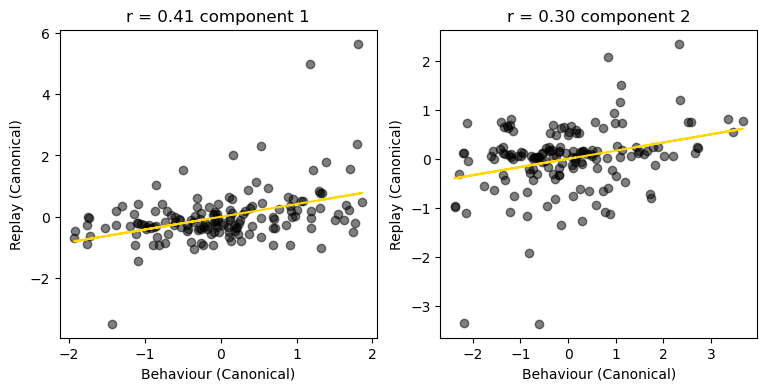

[0. 0.]
Component 1: corr=0.413, 95% CI=(0.393, 0.575)
Component 2: corr=0.299, 95% CI=(0.268, 0.458)


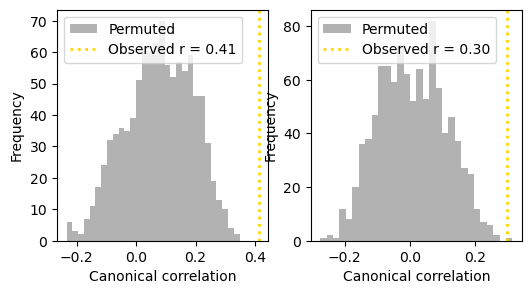

In [10]:
# plot correlations
n_components= 2
cca = CCA(n_components)
X_c, Y_c = cca.fit_transform(X_scaled, Y_scaled)
# Plot canonical variates
plot_canonical_variates(X_c, Y_c,n_components)
plt.show()

#plot
plot_correlation_permutation(X_scaled,Y_scaled,2)
# fdrcorrection returns boolean array of which are significant
significant, p_vals_corrected = fdrcorrection(pvals, alpha=0.05)
print(p_vals_corrected)
# print bootstrapped correlations
return_correlation_bootstrapped(X_scaled,Y_scaled)

# figure E & F

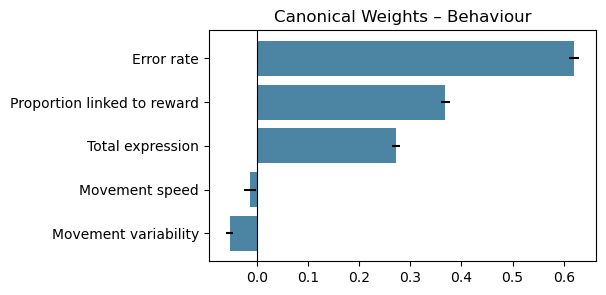

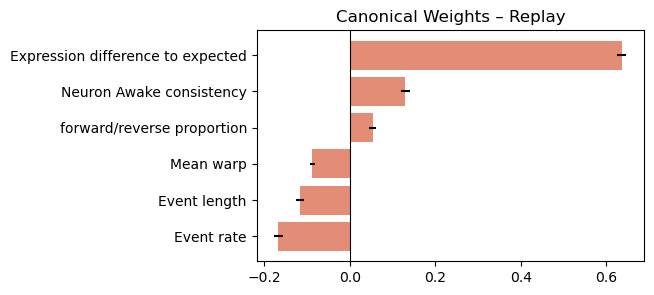

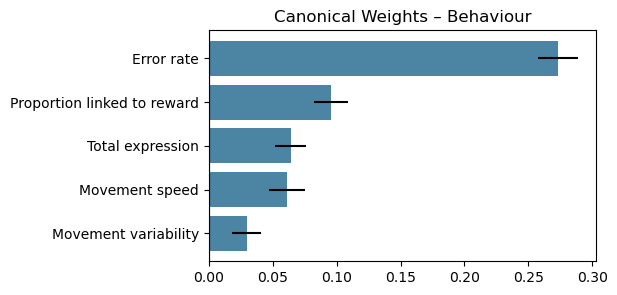

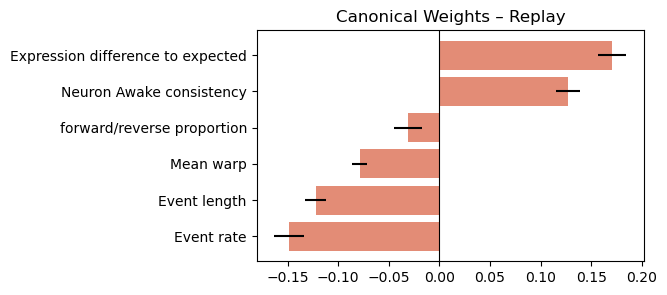

In [ ]:
# cv 1
plot_weights(X_scaled,Y_scaled,0)
# cv 2
plot_weights(X_scaled,Y_scaled,1)

# figure H

In [12]:
bts_outcome_matrix = pd.read_csv(r"C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\f4\stb_outcome.csv")
bts_predictor_matrix = pd.read_csv(r"C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\f4\stb_predictor.csv")
# scale and standardise the data
X_scaled, Y_scaled = stadardise_data(bts_predictor_matrix,bts_outcome_matrix)


c:\miniconda\envs\proc_replay_2025\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


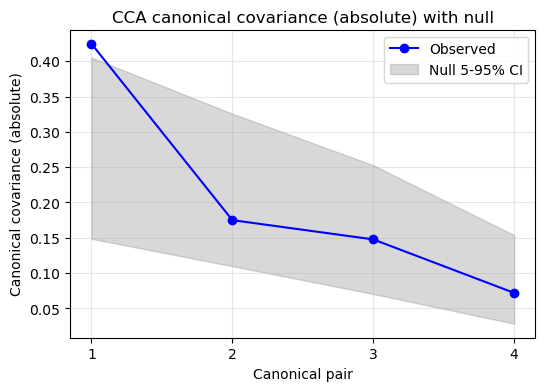

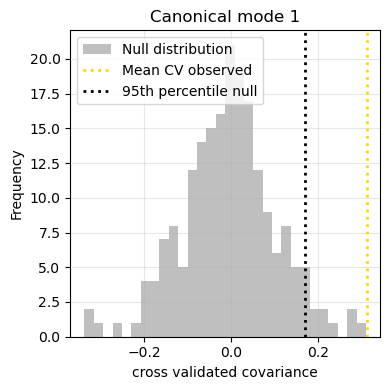

In [13]:

# Usage
cca_scree_absolute_with_null(X_scaled, Y_scaled, 5, n_components=4, n_shuffles=1000)

# cross validation
cv_covs, null_covs_all = compute_fold_wise_cross_validation(X_scaled,Y_scaled)
n_modes = 1  # number of canonical modes
plt.figure(figsize=(4*n_modes, 4))
for i in range(n_modes):
    plt.subplot(1, n_modes, i+1)
    obs = cv_covs[:, i]           # cross-validated covariances
    nulls = null_covs_all[:, i]   # null covariances
    null_95 = np.percentile(nulls, 95)
    # Histogram of null covariances
    plt.hist(nulls, bins=30, color='gray', alpha=0.5, label='Null distribution')
    # Mean CV observed
    plt.axvline(obs.mean(), color='gold', linestyle=':', linewidth=2, label='Mean CV observed')
    # 95th percentile of null
    plt.axvline(null_95, color='k', linestyle=':', linewidth=2, label='95th percentile null')
    plt.xlabel('cross validated covariance')
    plt.ylabel('Frequency')
    plt.title(f'Canonical mode {i+1}')
    plt.grid(alpha=0.3)
    if i == 0:
        plt.legend()
plt.tight_layout()

# figure I

Canonical correlation (component 1): 0.468


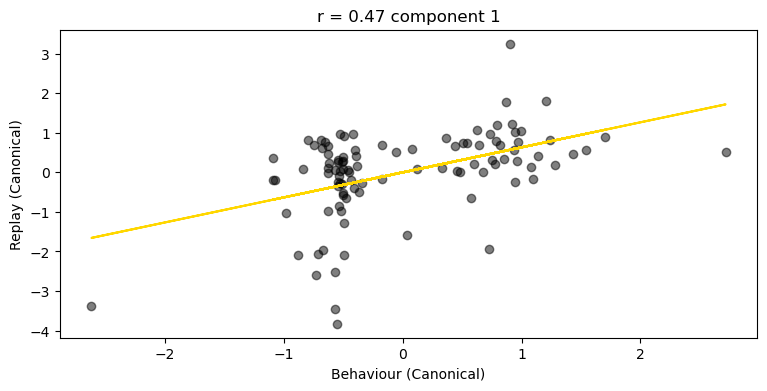

[0. 0.]
Component 1: corr=0.468, 95% CI=(0.446, 0.661)
Component 2: corr=0.241, 95% CI=(0.247, 0.486)


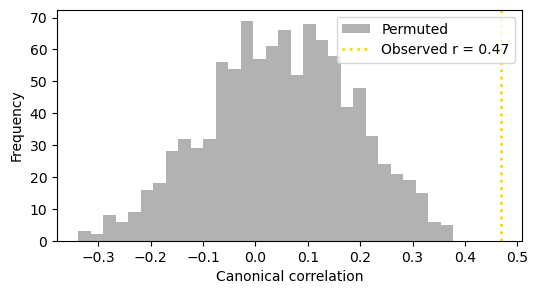

In [14]:
# plot correlations
n_components= 1
cca = CCA(n_components)
X_c, Y_c = cca.fit_transform(X_scaled, Y_scaled)
# Plot canonical variates
plot_canonical_variates(X_c, Y_c,n_components)
plt.show()

#plot
plot_correlation_permutation(X_scaled,Y_scaled,1)
# fdrcorrection returns boolean array of which are significant
significant, p_vals_corrected = fdrcorrection(pvals, alpha=0.05)
print(p_vals_corrected)
# print bootstrapped correlations
return_correlation_bootstrapped(X_scaled,Y_scaled)

# figure J

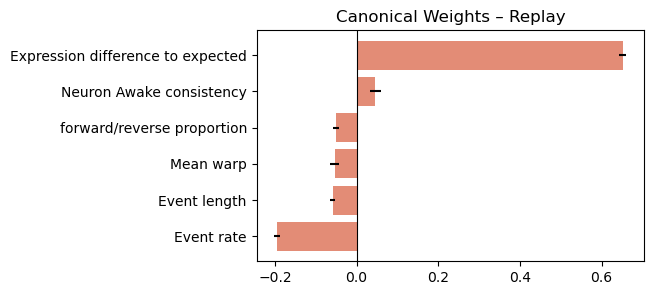

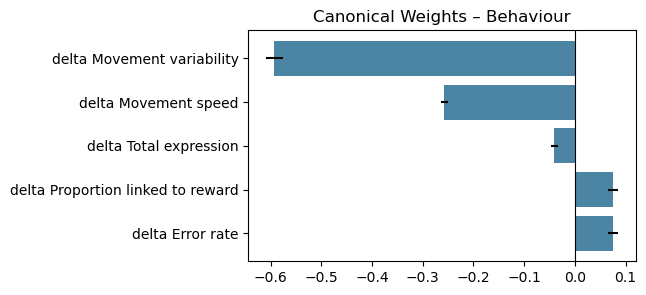

In [49]:
# cv 1
plot_weights_delta(X_scaled,Y_scaled,1)